In [270]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [271]:
# load inflow dataset into dataframe
inflow_data = pd.read_excel("InflowData_1.xlsx")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")

# print first two rows
inflow_data.head(3)

,DMA A (L/s),DMA B (L/s),DMA C (L/s),DMA D (L/s),DMA E (L/s),DMA F (L/s),DMA G (L/s),DMA H (L/s),DMA I (L/s),DMA J (L/s)
Date-time CET-CEST (DD/MM/YYYY HH:mm),,,,,,,,,,
2021-01-01 00:00:00,NaN,NaN,3.7000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,NaN,NaN,3.5625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00,NaN,NaN,3.2725,NaN,NaN,NaN,NaN,NaN,NaN,NaN


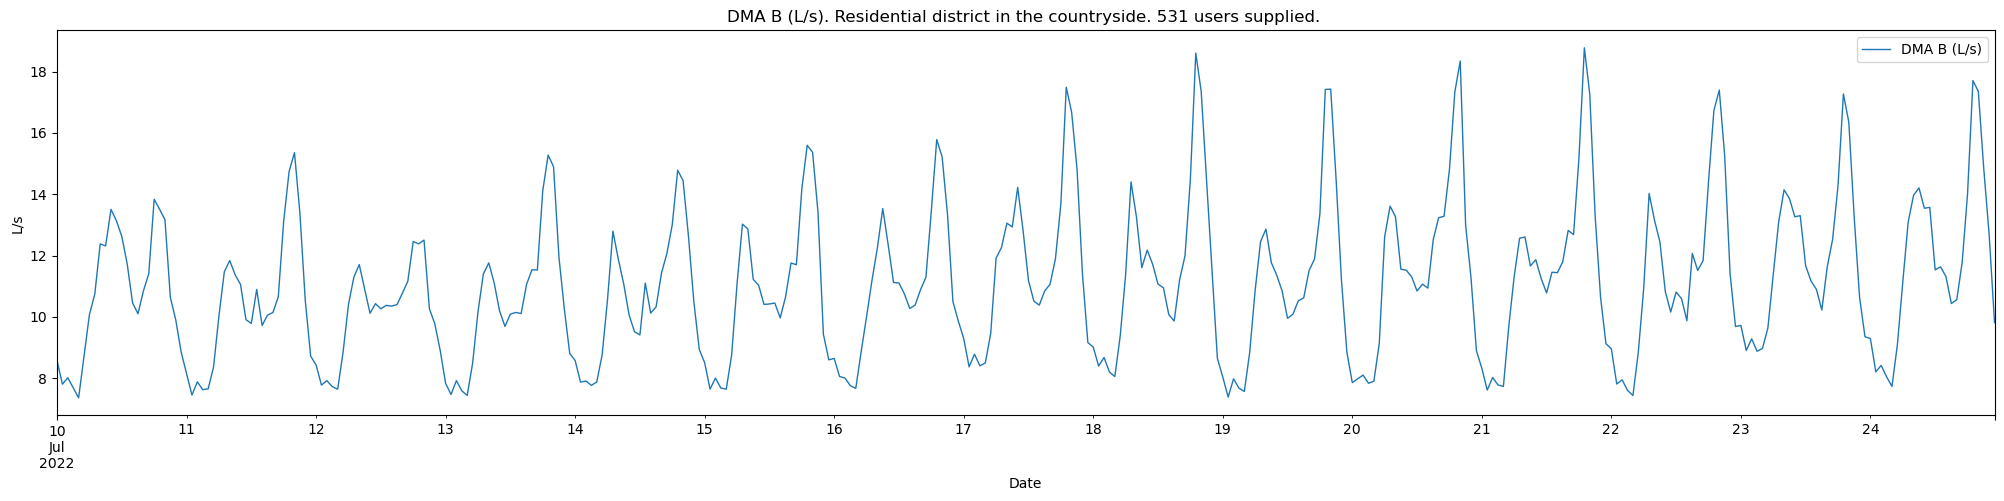

In [272]:
# define start and end dates for analysis
start = '2022-07-10'
end = '2022-07-24'

# plot time series for start and end dates
i = 1
fig, ax = plt.subplots()
inflow_data[start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1)
plt.title(dma_list[i] + ". " + dma_descripton[i] +". "+ str(users_supplied[i]) + " users supplied. ")
plt.xlabel("Date")
plt.ylabel("L/s")
plt.show()

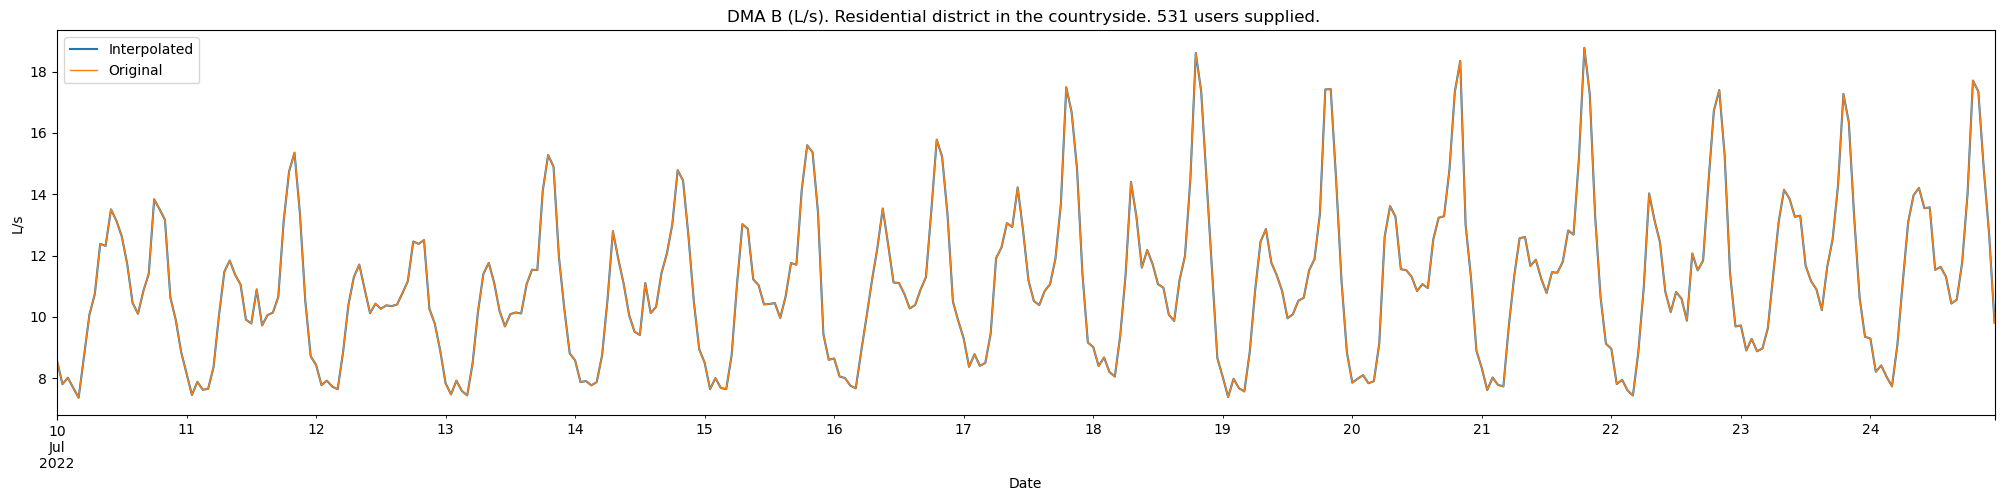

In [273]:
# select dma for analysis
dma = 'DMA B (L/s)'

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# copy data from dataframe in a new time series dataframe
tseries_df = inflow_data[dma][start:end].copy()

# fill missing values with interpolation technique
tseries_df.interpolate(limit_direction='both',inplace=True)

# plot original and interpolated time series for selected dma
fig, ax = plt.subplots()
tseries_df.plot(label='Interpolated')
inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
plt.xlabel("Date")
plt.ylabel("L/s")
plt.legend()
plt.show()

In [274]:
# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# create an utility metric function
def print_metrics(y_true, y_pred, model_name):
    mae_ = mean_absolute_error(y_true, y_pred)
    rmse_ = mean_squared_error(y_true, y_pred, square_root = True)
    mape_ = mean_absolute_percentage_error(y_true, y_pred)
    smape_ = mean_absolute_percentage_error(y_true, y_pred, symmetric = True)
    
    dict_ = {'MAE': mae_, 'RMSE': rmse_,
             'MAPE': mape_, 'SMAPE': smape_ }
    
    df = pd.DataFrame(dict_, index = [model_name])
    return(df.round(decimals = 2))

def print_performance_indicators(y_obs,y_pred):
    PI_1 = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    PI_2 = np.max(np.abs(y_obs - y_pred))

    PI_3 = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    print('Performance indicators')

    print(f"P1      P2      P3")
    print(f"{PI_1:{1}.{3}}  {PI_2:{1}.{3}}  {PI_3:{1}.{3}}  \n")

In [275]:
y = tseries_df
y_train, y_test = temporal_train_test_split(y, test_size = 168)

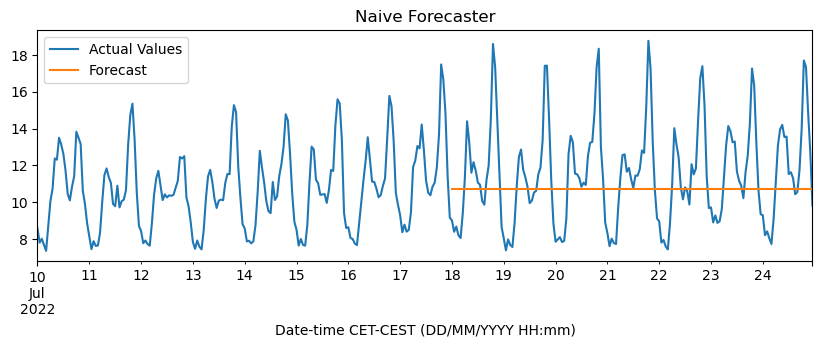

,MAE,RMSE,MAPE,SMAPE
Naive Forecaster,2.17,2.81,0.18,0.19


In [276]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy = 'mean')
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

fig, ax = plt.subplots(figsize = (10,3))
tseries_df.plot(title = 'Naive Forecaster', ax = ax)
y_pred.plot(ax = ax)
ax.legend(['Actual Values', 'Forecast'])
plt.show()

print_metrics(y_test, y_pred, 'Naive Forecaster')

In [277]:
print_performance_indicators(y_test,y_pred)

Performance indicators
P1      P2      P3
2.15  8.07  2.17  



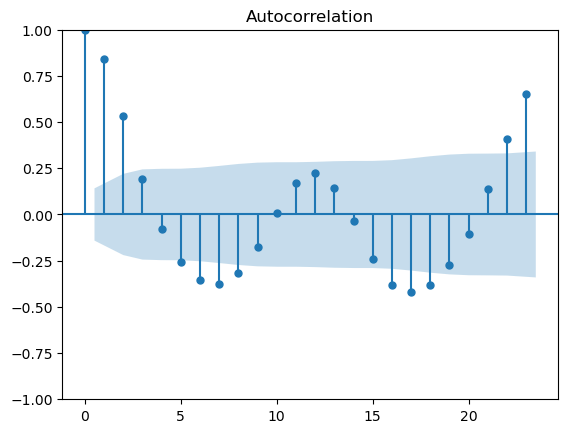

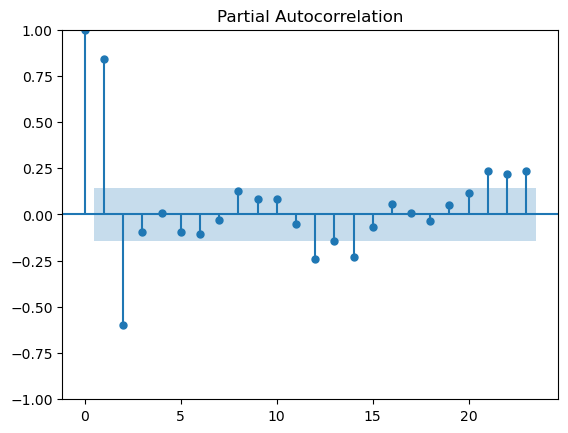

In [278]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(y_train)

pacf_original = plot_pacf(y_train)

In [279]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(y_train)
print(f'p-value: {adf_test[1]}')

p-value: 1.1083346321892646e-09


In [280]:
# y_train_diff = y_train.diff().dropna()
# y_train_diff.plot()

In [281]:
# the statsmodel package applies the difference already if needed.
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y_train, order=(2,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            DMA B (L/s)   No. Observations:                  192
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -254.698
Date:                Tue, 05 Dec 2023   AIC                            517.397
Time:                        11:53:33   BIC                            530.427
Sample:                    07-10-2022   HQIC                           522.674
                         - 07-17-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6746      0.292     36.582      0.000      10.103      11.246
ar.L1          1.3674      0.056     24.508      0.000       1.258       1.477
ar.L2         -0.6202      0.056    -11.001      0.0

/home/carlos/miniconda3/envs/water-demand-forecasting/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/carlos/miniconda3/envs/water-demand-forecasting/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/carlos/miniconda3/envs/water-demand-forecasting/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


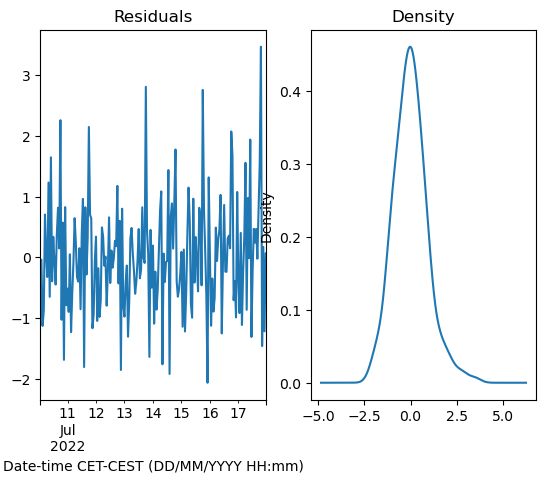

In [282]:
# if the model is good, the residuals should look like white noise
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

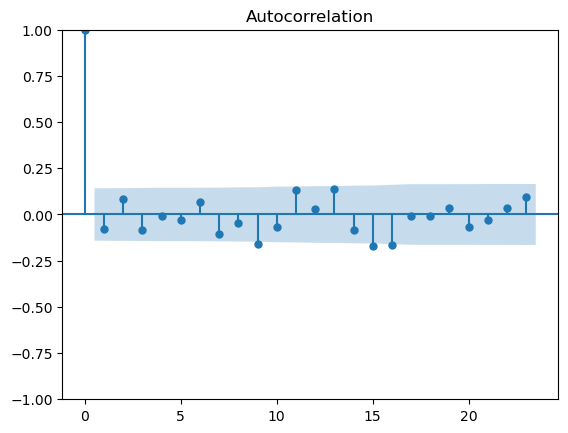

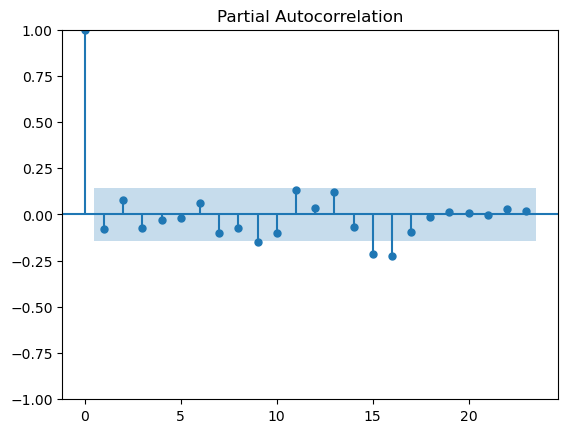

In [283]:
# we can also look at the ACF and PACF of the residuals
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

In [284]:
# The lower lags barely show any significant 'spikes'
# These show that the residuals are close to white noise

# Let's calculate the predictions and plot them together with the actual series, including the test set

y_pred = model_fit.forecast(len(y_test))

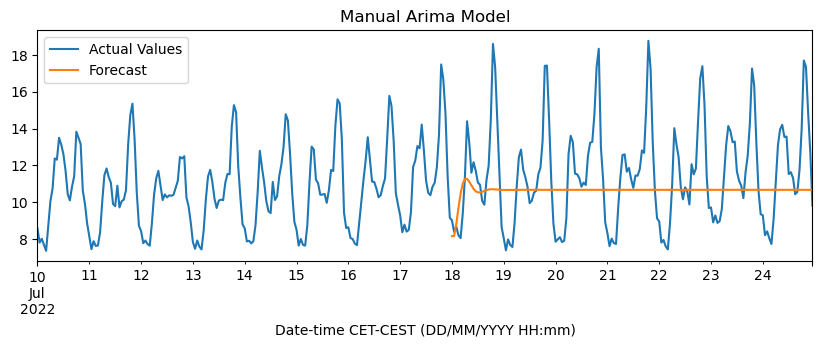

,MAE,RMSE,MAPE,SMAPE
Manual Arima,2.13,2.79,0.18,0.18


In [285]:
fig, ax = plt.subplots(figsize = (10,3))
tseries_df.plot(title = 'Manual Arima Model', ax = ax)
y_pred.plot(ax = ax)
ax.legend(['Actual Values', 'Forecast'])
plt.show()
print_metrics(y_test, y_pred, 'Manual Arima')

In [286]:
# import pmdarima as pm
# auto_arima = pm.auto_arima(y_train, stepwise=True, seasonal=True, trend=False)
# auto_arima

In [287]:
# y_pred = auto_arima.predict(n_periods=len(y_test))

# fig, ax = plt.subplots(figsize = (10,3))
# tseries_df.plot(title = 'Auto Arima Model', ax = ax)
# y_pred.plot(ax = ax)
# ax.legend(['Actual Values', 'Forecast'])
# plt.show()
# print_metrics(y_test, y_pred, 'Autoarima model')

/home/carlos/miniconda3/envs/water-demand-forecasting/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/carlos/miniconda3/envs/water-demand-forecasting/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/carlos/miniconda3/envs/water-demand-forecasting/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        DMA B (L/s)   No. Observations:                  192
Model:             ARIMA(2, 0, 2)x(0, 1, [1], 24)   Log Likelihood                -164.719
Date:                            Tue, 05 Dec 2023   AIC                            341.438
Time:                                    11:54:11   BIC                            360.182
Sample:                                07-10-2022   HQIC                           349.045
                                     - 07-17-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1768      0.326     -0.542      0.588      -0.817       0.463
ar.L2          0.3916      0.246   

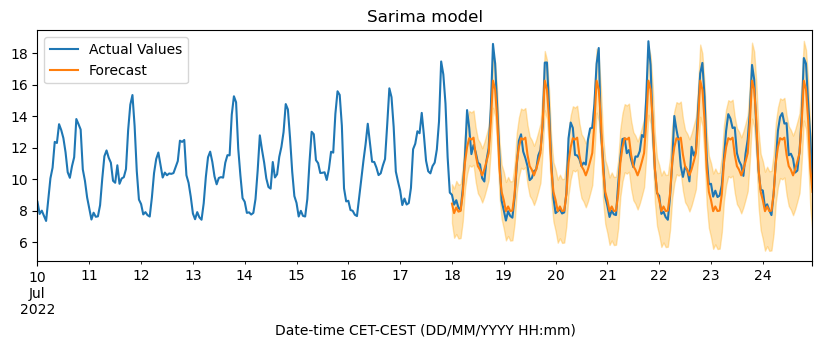

In [292]:
# implement sarima model
model = ARIMA(y_train, order=(2,0,2), seasonal_order=(0,1,1,24))
model_fit = model.fit()
print(model_fit.summary())

# y_pred = model_fit.forecast(len(y_test))

# fig, ax = plt.subplots(figsize = (10,3))
# tseries_df.plot(title = 'Sarima model', ax = ax)
# y_pred.plot(ax = ax)
# ax.legend(['Actual Values', 'Forecast'])
# plt.show()
# print_metrics(y_test, y_pred, 'Sarima forecaster')

y_pred = model_fit.get_forecast(len(y_test)).summary_frame(alpha=0.05)

fig, ax = plt.subplots(figsize = (10,3))
tseries_df.plot(title = 'Sarima model', ax = ax)
y_pred.plot(y='mean',ax = ax)
ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
ax.legend(['Actual Values', 'Forecast'])
plt.show()

In [293]:
print_performance_indicators(y_test,y_pred['mean'])

Performance indicators
P1      P2      P3
0.664  2.64  0.727  

